**Structural Health Monitoring (SHM)** is the process of collecting and analyzing data related to structural health of a structure usually through autonomous monitoring systems.

Topics in SHM:
1. Signal Processing
2. Time Series Analysis
3. Feature Extraction

**Predictive Maintenance (PredM)** is the maintenance strategy that utilizes data (usually obtained through SHM) to make informed decision to carry out maintenance activities so as to optimize resources usage and minimize risks of failure. This contrasts with other maintenance philosophies like reactive maintenance and scheduled maintenance.

Topics in PredM:
1. Anomaly Detection
2. Remaining Useful Life Prediction



The Vanersborg bridge is a catenary steel bridge in Sweden. A monitoring system was set up and measurements started in 2021 for the bridge. [Research Article](https://www.sciencedirect.com/science/article/pii/S2352340923008004?via%3Dihub)

![Vanersborg Bridge](https://usercontent.one/wp/www.iotbridge.se/wp-content/uploads/2024/05/Vanersborg-bridge.jpg?media=1641573162)

The subset of data collected is publicly available for research purposes. It can be obtained from [this link](https://zenodo.org/records/8300495).

*[Learn about the application of SHM & PredM in this post.](https://www.iotbridge.se/application-vanersborg/)*



The obtained data is collection of several time series sampled at 200Hz during opening events. The time series consists data for:
1. Acceleration at 5 points (channels 18 to 22)
2. Strain at 16 points (channels 4 to 19)
3. Inclination (channel 25)
4. Weather parameters - wind direction, wind speed and air temperature (channels 28 to 30)

The data for each opening event is stored in separate CSV file. Each file is processed to a single record with important values on time and frequency domains. For the 64 files, we obtain a processed data with 64 records.

The processed data contains `min`, `max`, `rms` and `fmax` (peak frequency greater than 0.5 Hz obtained through FFT) values.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import IsolationForest
from numpy import where
from sklearn.preprocessing import StandardScaler

PROJECT_ROOT = Path.cwd().parent
RAW_DATA_DIR = PROJECT_ROOT / 'data' / 'raw'
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)


In [48]:
data_path = RAW_DATA_DIR / 'shm_data.csv'
df_raw = pd.read_csv(data_path)
df = df_raw.copy()
#df.sample(2)
#df.dtypes

# this merged csv file has n rows representing n opening events
# each opening event (few secons) had data at incoming at 1/200 sec so for 2 sec maybe 400 data points all squashed into one row for the csv file we are dealing with today



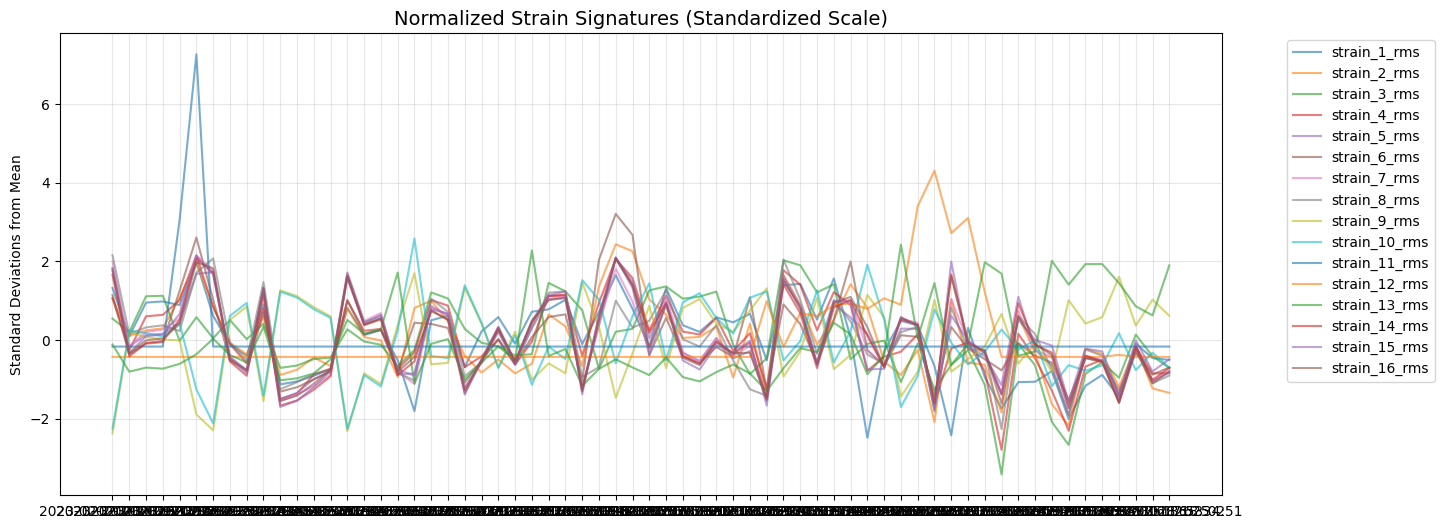

In [49]:

def plot_normalized_trends(df: pd.DataFrame) -> None:
    """
    Standardizes all metrics to a mean of 0 and variance of 1.
    Allows for visual comparison of cyclic signatures across different units.
    """
    df_plot = df.copy().sort_values('timestamp')
    numeric_cols = df_plot.select_dtypes(include=[np.number]).columns.tolist()

    # Clerical Operation: Standardize the scales
    scaler = StandardScaler()
    df_plot[numeric_cols] = scaler.fit_transform(df_plot[numeric_cols])

    # Plotting only a subset (e.g., Strain RMS) to keep it legible
    strain_cols = [c for c in numeric_cols if 'strain' in c and '_rms' in c]

    plt.figure(figsize=(15, 6))
    for col in strain_cols:
        plt.plot(df_plot['timestamp'], df_plot[col], label=col, alpha=0.6)

    plt.title("Normalized Strain Signatures (Standardized Scale)", fontsize=14)
    plt.ylabel("Standard Deviations from Mean")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_normalized_trends(df)

In [ ]:

def plot_thermal_correlation(df: pd.DataFrame, strain_col: str, temp_col: str) -> None:
    """
    Plots the relationship between thermal load and structural response.
    Points deviating from the main 'cluster' are likely structural anomalies.
    """
    plt.figure(figsize=(10, 6))

    # Clerical Operation: Create scatter plot with a regression trend
    # by default regplot calcs 95% CI via bootstrapping
    sns.regplot(data=df, x=temp_col, y=strain_col,
                scatter_kws={'alpha':0.6}, line_kws={'color':'red'})

    plt.title(f"Thermal Correlation: {strain_col} vs {temp_col}", fontsize=12)
    plt.xlabel("Air Temperature (RMS)")
    plt.ylabel("Measured Strain (RMS)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Execution: Targeting a specific sensor pair

#debug=[]
for i in range(1,17,1):
   # strain_str = str(f'strain_{i}+_rms')
    strain_str = f'strain_{i}_rms'
    #debug.append(strain_str)
    #plot_thermal_correlation(df, strain_str, 'air_temperature_rms')


Generating trends for 26 primary metrics...


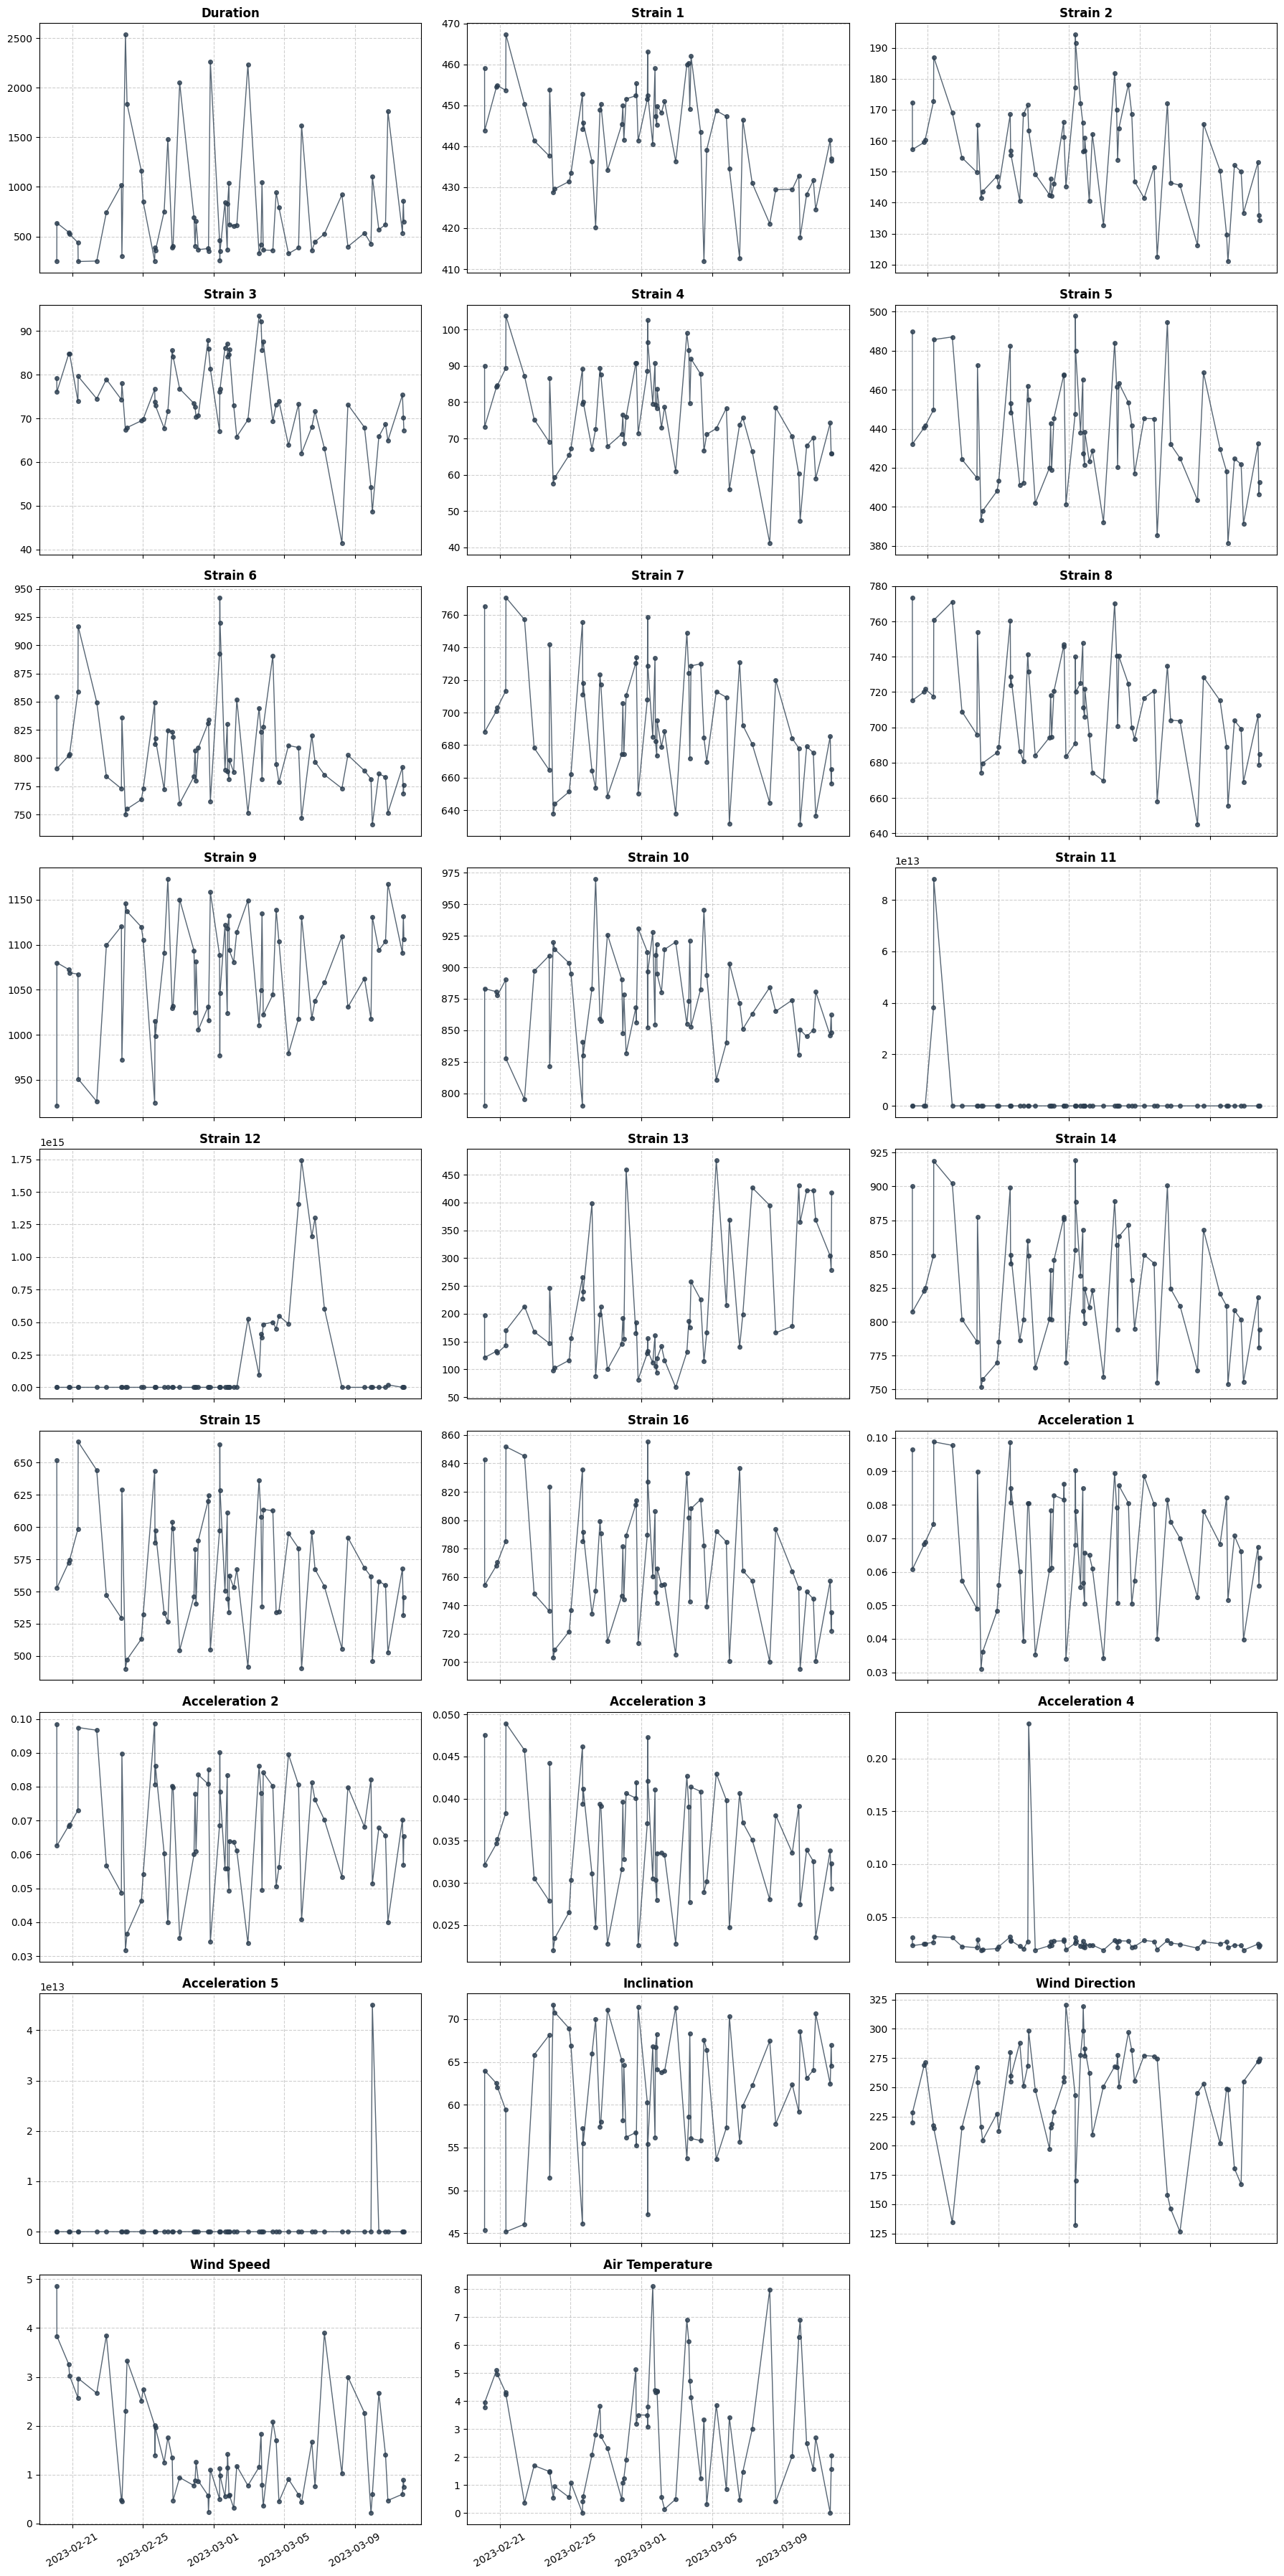

In [51]:
def plot_sensor_trends(df: pd.DataFrame) -> None:
    """
    Categorizes and plots all aggregated sensor data over time.
    Essential for identifying long-term structural drift in Himalayan conditions.
    """
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df_sorted = df.sort_values('timestamp')

    # Identify unique sensors (strip _min, _max, _rms, _fmax)
    all_cols = df_sorted.select_dtypes(include=[np.number]).columns.tolist()

    # We focus on RMS as the primary indicator of structural health/energy
    # Why? RMS represents the Total Energy produced by the bridge during an event.
    rms_cols = [c for c in all_cols if '_rms' in c or c == 'duration']

    n_cols = 3
    n_rows = (len(rms_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True)
    axes = axes.flatten()

    print(f"Generating trends for {len(rms_cols)} primary metrics...")

    for i, col in enumerate(rms_cols):
        axes[i].plot(df_sorted['timestamp'], df_sorted[col],
                    color='#2c3e50', marker='o', markersize=4, linestyle='-', linewidth=1, alpha=0.8)

        # Engineering Standard: Clean up label for display
        display_name = col.replace('_rms', '').replace('_', ' ').title()
        axes[i].set_title(display_name, fontsize=12, fontweight='bold')
        axes[i].grid(True, linestyle='--', alpha=0.6)
        axes[i].tick_params(axis='x', rotation=30)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()



# Visualize the primary energy signatures (RMS) for all sensors
plot_sensor_trends(df)

In [52]:
# where is useful to filter indices of a numpy array
# based on a condition


# TODO: replace None to filter out the timestamp
filtered_df = df.iloc[:, 1:]
# or via loc[:, df.columns[1:]]

# for std SHM, IF is std because it isolates outliers, and as such failures are assumed to be sudden and distinct
# falls off when a failure is gradual like a creep

# TODO: train the model using "fit" method
#contamination is the estimated % of anamolies in the dataset (95%CI)
model = IsolationForest(contamination=0.05,  random_state=42).fit(filtered_df)

# TODO: calculate anomaly scores using "decision_function" method

# Calculate scores: Higher = Normal, Lower/Negative = Anomaly
df['anomaly_score'] = model.decision_function(filtered_df)

sorted_df = df.sort_values(by = 'anomaly_score')

display(sorted_df[['timestamp', 'anomaly_score']].head(5))

,timestamp,anomaly_score
59,2023-03-09 23:45:25,-0.085291
55,2023-03-08 06:25:19,-0.022452
52,2023-03-06 13:33:15,-0.004704
7,2023-02-21 08:13:01,-0.000352
51,2023-03-05 23:37:24,0.001993


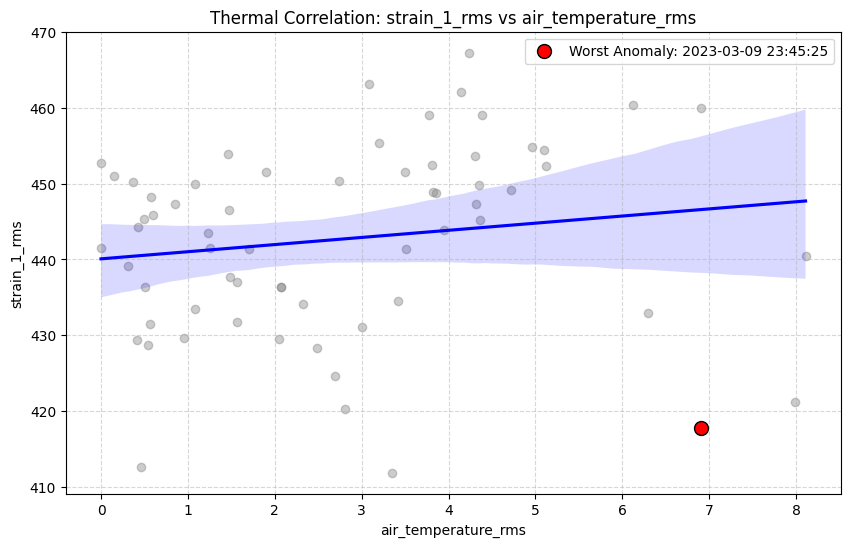

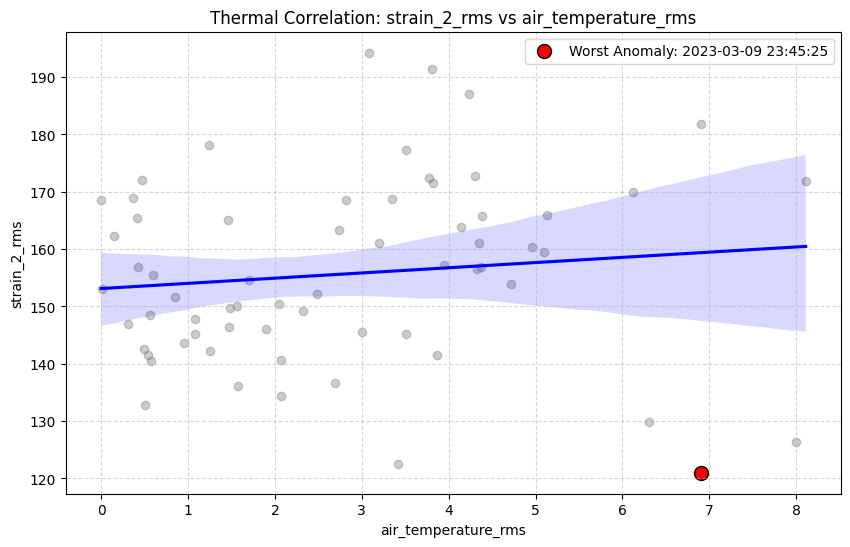

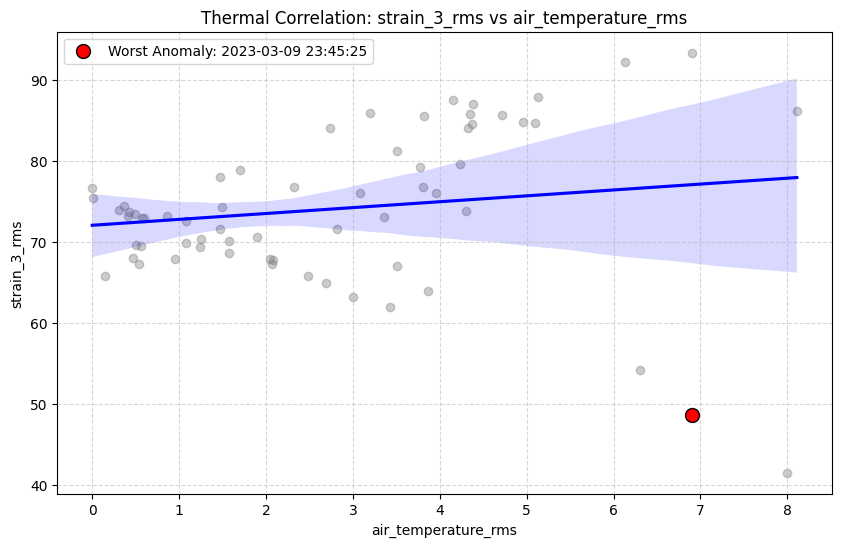

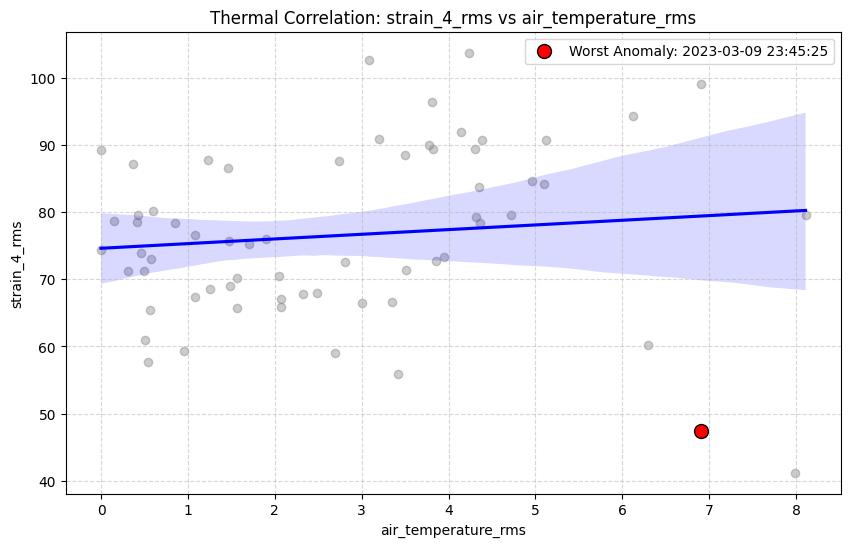

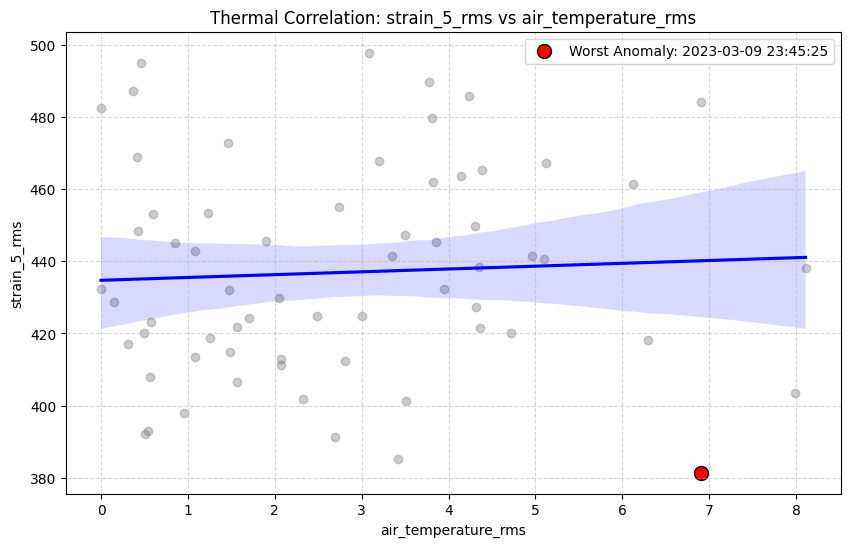

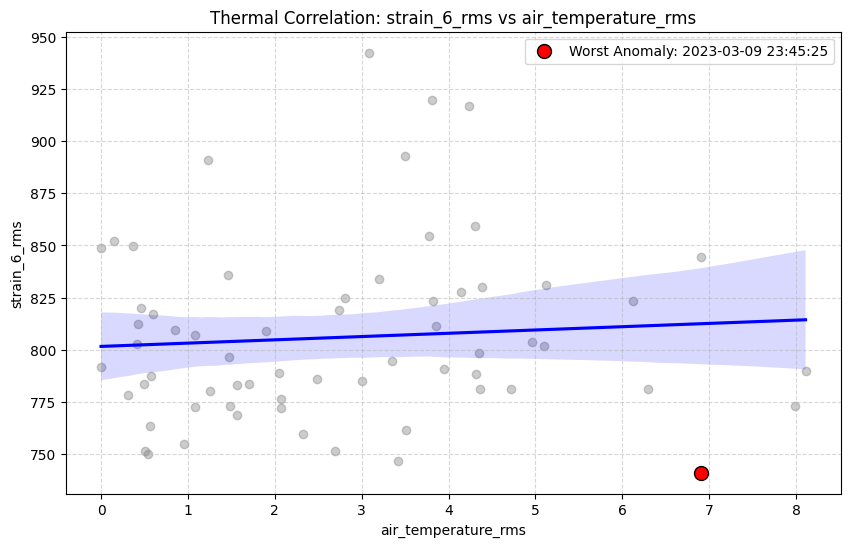

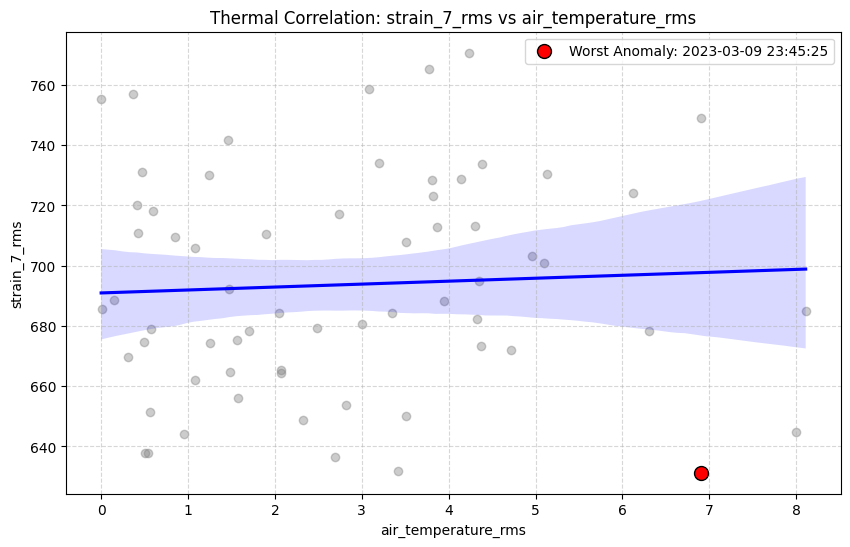

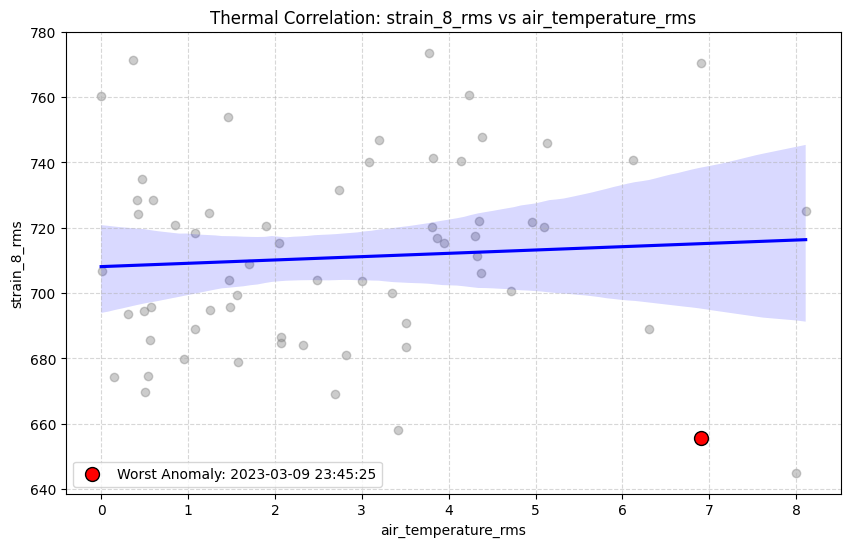

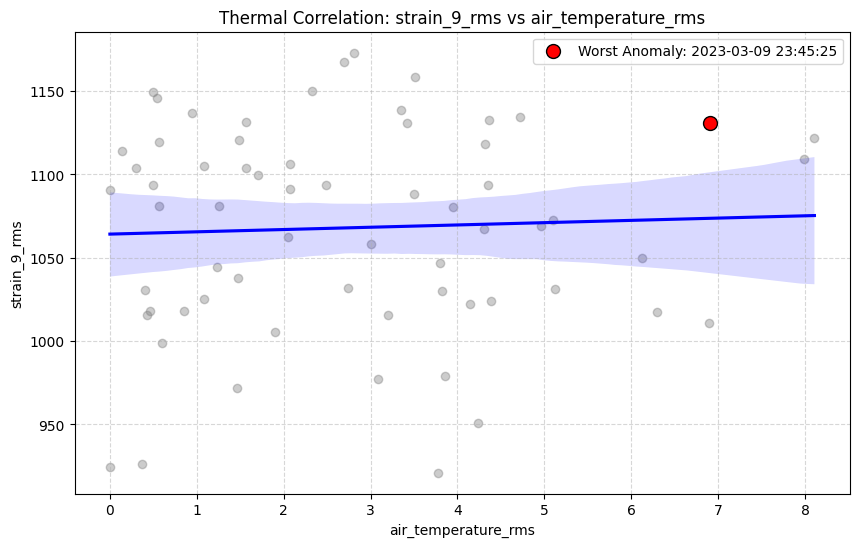

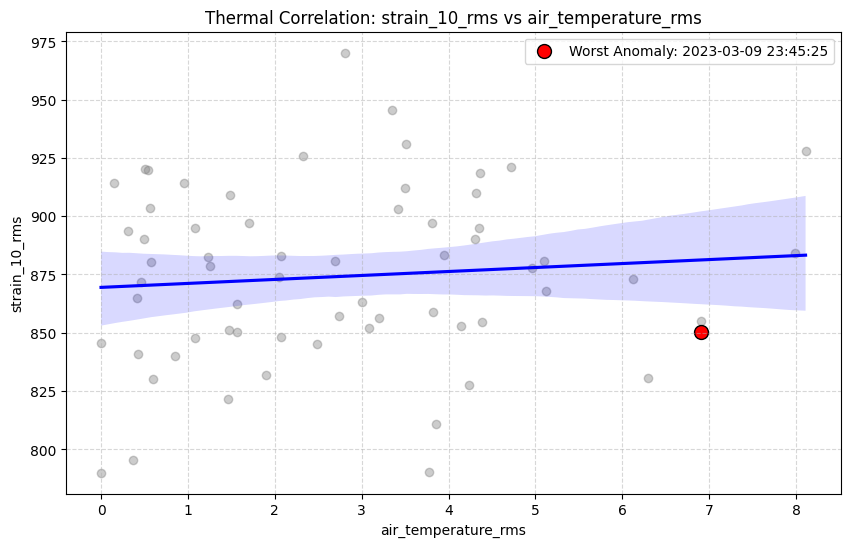

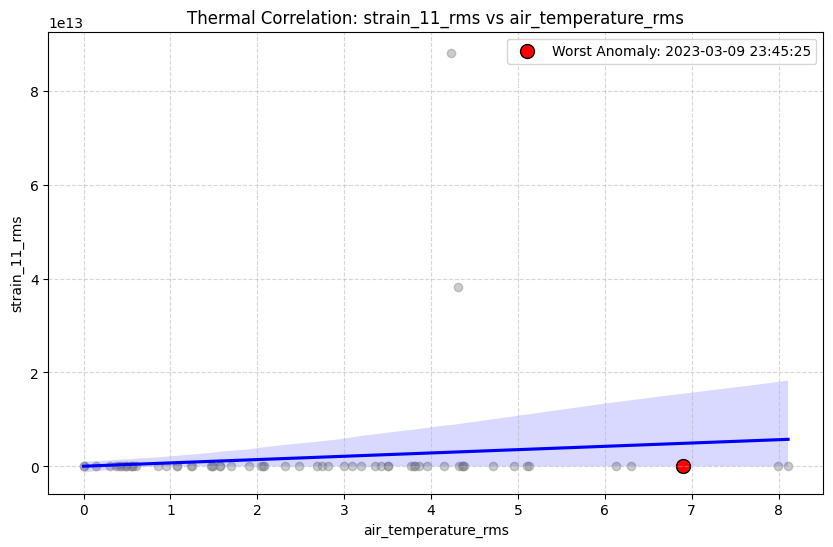

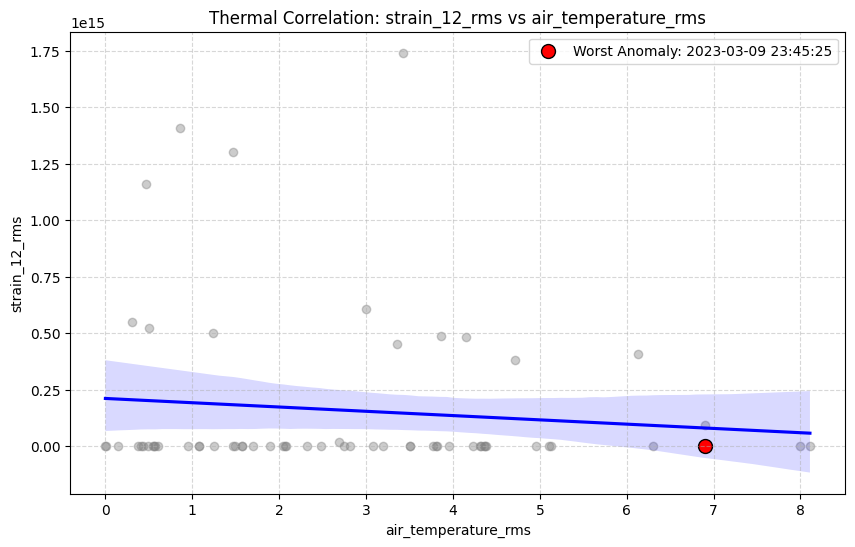

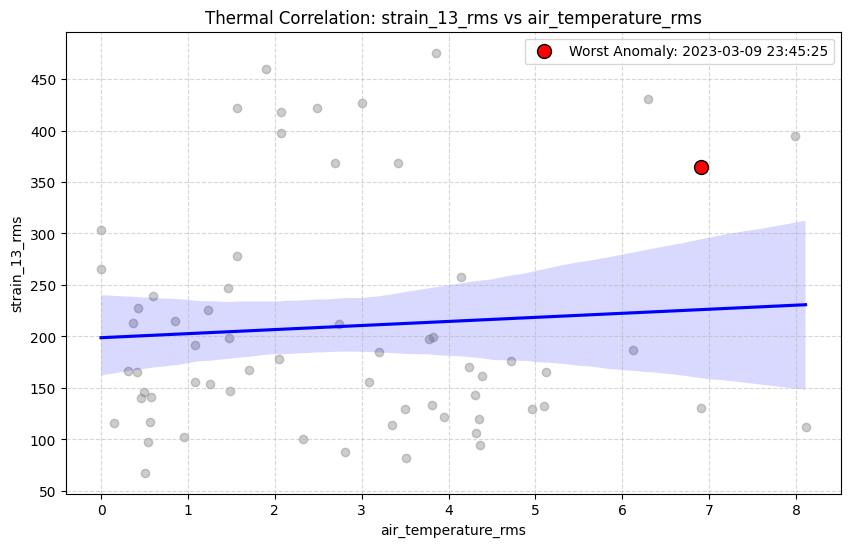

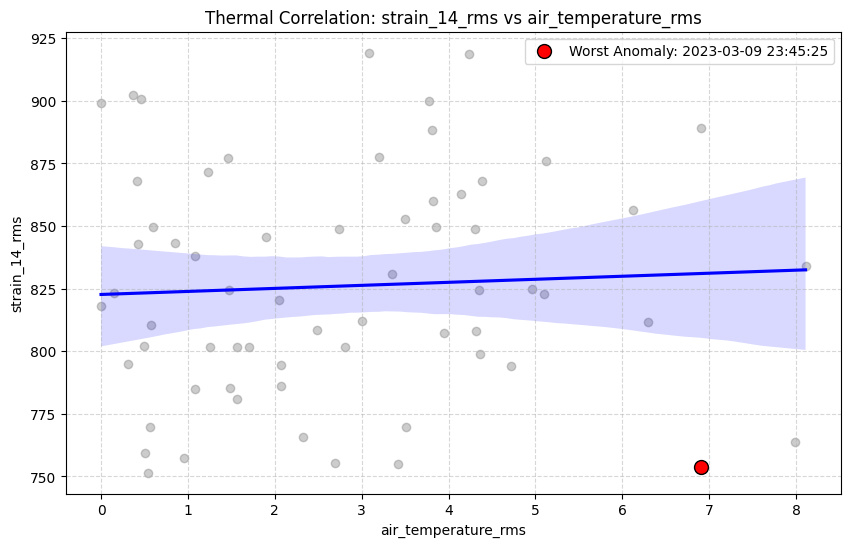

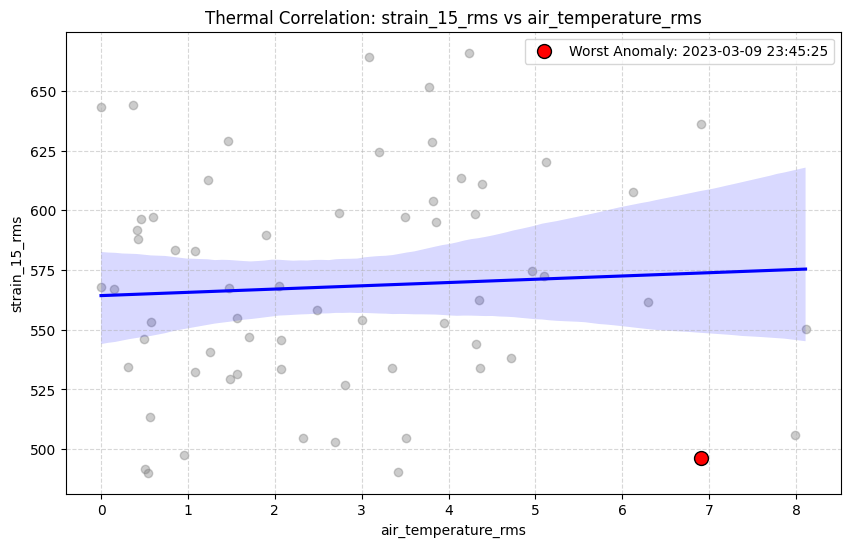

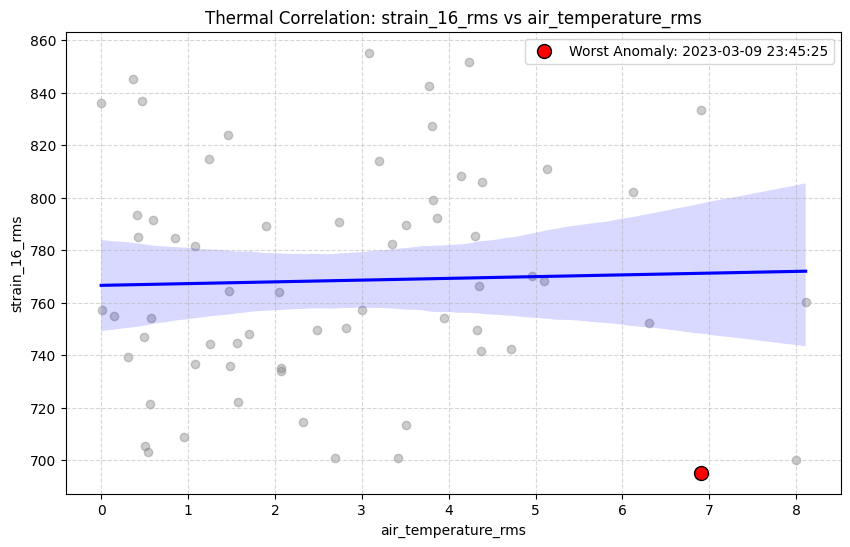

In [ ]:
def plot_thermal_correlation_with_anomaly(df: pd.DataFrame, strain_col: str, temp_col: str) -> None:
    """
    Plots thermal load vs response and highlights the most suspicious point.
    """
    plt.figure(figsize=(10, 6))

    # 1. Plot all points (The Baseline)
    # by default regplot calcs 95% CI via bootstrapping
    sns.regplot(data=df, x=temp_col, y=strain_col,
                scatter_kws={'alpha':0.4, 'color':'grey'}, line_kws={'color':'blue'})

    # 2. Identify the 'Worst' Anomaly (The Engineering Target)
    if 'anomaly_score' in df.columns:
        worst_idx = df['anomaly_score'].idxmin()
        worst_point = df.loc[worst_idx]

        plt.scatter(worst_point[temp_col], worst_point[strain_col],
                    color='red', s=100, edgecolors='black', label=f"Worst Anomaly: {worst_point['timestamp']}")
        plt.legend()

    plt.title(f"Thermal Correlation: {strain_col} vs {temp_col}", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Execution: Execute for the known bad sensor

for i in range(1,17,1):
   # strain_str = str(f'strain_{i}+_rms')
    strain_str = f'strain_{i}_rms'
    #debug.append(strain_str)
    plot_thermal_correlation_with_anomaly(df, strain_str, 'air_temperature_rms')

Task 3: Remaining Useful Life (RUL)
Find the timestamp with lowest anomaly_score as failure_timestamp.
Set all records before the failure to pre_damage_df.
For the pre_damage_df estimate the remaining useful life (RUL) by timestamp - failure_timestamp
Answer the following questions:

What is the "maximum" useful life recorded?
How would you predict RUL for new records? (Using the features, not the anomaly_score)

In [54]:
min_anomaly_score_index = None # update from output of above code cell

failure_timestamp = df.loc[min_anomaly_score_index, 'timestamp']

print(f"The timestamp of the predicted failure event is: {failure_timestamp}")

KeyError: None

In [ ]:
# convert the timestamps to "datetime" objects for comparison
df['timestamp'] = pd.to_datetime(df['timestamp'])
failure_timestamp = pd.to_datetime(failure_timestamp)

# TODO: filter data to include only observations before the failure event
pre_failure_df = None

# Remaining Useful Life (RUL) for each pre-failure data point
pre_failure_df['RUL'] = (failure_timestamp - pre_failure_df['timestamp']).total_seconds() / (24 * 3600)

display(pre_failure_df[['timestamp', 'RUL']].head())